In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
import imageio
import glob
import os

2024-05-07 10:23:43.076326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 10:23:43.076441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 10:23:43.238059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#necessary step to add for, if you want to train the model on GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Loading Data and creating Dataset

In [4]:
#extracting path for both the types of MRI images
t1_files = r'/kaggle/input/t1-and-t2-mri-images/MRI+T1_T2+Dataset/Tr1/TrainT1'
t2_files = r"/kaggle/input/t1-and-t2-mri-images/MRI+T1_T2+Dataset/Tr2/TrainT2"

In [5]:
from PIL import Image

In [6]:
# Function to load images from a directory and convert them to numpy arrays
def load_images_as_arrays(directory):
    images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            img = Image.open(filepath)
            img_array = np.array(img)
            images.append(img_array)
    return images

# Load images from directories and convert them to numpy arrays
imgT1 = load_images_as_arrays(t1_files)
imgT2 = load_images_as_arrays(t2_files)

In [7]:
#getting the shape of both the images
print("Shape of type1 MRI",imgT1[0].shape)
print("Shape of type2 MRI",imgT2[0].shape)

Shape of type1 MRI (217, 181)
Shape of type2 MRI (217, 181)


#### Visualizing the images of both types

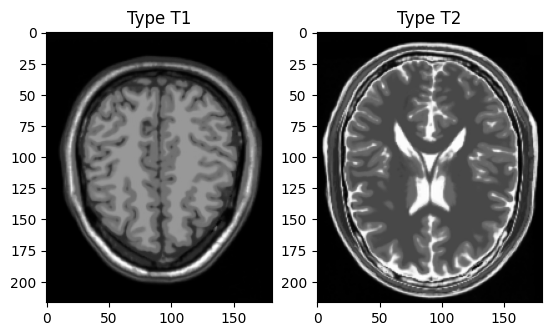

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imgT1[0], cmap='gray')
ax2.imshow(imgT2[0], cmap='gray')
ax1.title.set_text('Type T1')
ax2.title.set_text('Type T2')
plt.show()

In [9]:
#setting epochs, epoch to schedule the learning rate decay, batch size and the length of dataset
EPOCHS = 200
DECAY_RATE_EPOCH = 100
BATCH_SIZE = 4
len_dataset = max(len(t1_files), len(t2_files)) // BATCH_SIZE

### Stacking the T1 images to form a single array of images, and same is done for the T2 image

In [10]:
imgT1 = np.stack(imgT1, axis = 0)
imgT1.shape

(43, 217, 181)

In [11]:
imgT2 = np.stack(imgT2, axis = 0)
imgT2.shape

(46, 217, 181)

#### Normalizing images and making pixel values ranging betwwen [-1.0, 1.0]

In [12]:
imgT1 = imgT1/127.5 - 1
imgT2 = imgT2/127.5 - 1

#### Visualizing the images after the normalization

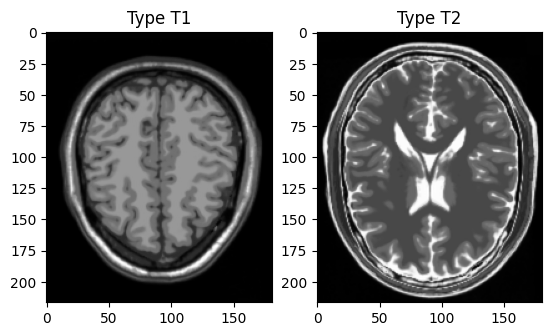

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imgT1[0], cmap='gray')
ax2.imshow(imgT2[0], cmap='gray')
ax1.title.set_text('Type T1')
ax2.title.set_text('Type T2')
plt.show()

# Data Processing
- Resizing Image
- Reshaping Images
- Creating Dataset

 Resizing image to (256, 256, 1) as 256 is in the power of 2, it will be easy for building the model architecture as well as for training

In [14]:
typet1_data = np.zeros((imgT1.shape[0], 256, 256, 1))
for index, img in enumerate(imgT1):
    typet1_data[index, :, :, :] = resize(img, (256, 256, 1))
typet1_data.shape

(43, 256, 256, 1)

In [15]:
typet2_data = np.zeros((imgT2.shape[0], 256, 256, 1))
for index, img in enumerate(imgT2):
    typet2_data[index, :, :, :] = resize(img, (256, 256, 1))
typet2_data.shape

(46, 256, 256, 1)

Reshaping images to the same size (256, 256, 1)

In [16]:
typet1_data = typet1_data.reshape(typet1_data.shape[0], 256, 256, 1).astype('float32')
typet2_data = typet2_data.reshape(typet2_data.shape[0], 256, 256, 1).astype('float32')

#### Creating dataset after reshaping image to (256,256,1) as tensorflow requries at least one channel
Note: seed = 100 is used to avoid randomness for the further retraining of models

In [17]:
typet1_data = tf.data.Dataset.from_tensor_slices(typet1_data).shuffle(imgT1.shape[0], seed=100).batch(BATCH_SIZE)
typet2_data = tf.data.Dataset.from_tensor_slices(typet2_data).shuffle(imgT2.shape[0], seed=100).batch(BATCH_SIZE)

#### Visualizing the sample image from the above dataset created for both the type of MRI

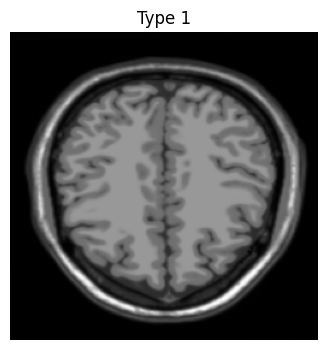

In [18]:
sample_typet1 = next(iter(typet1_data))
plt.figure(figsize=(4, 4))
plt.imshow(sample_typet1[0].numpy()[:, :, 0], cmap='gray')
plt.title('Type 1')
plt.axis('off')
plt.show()

In [19]:
plt.savefig('output_typet1.png')

<Figure size 640x480 with 0 Axes>

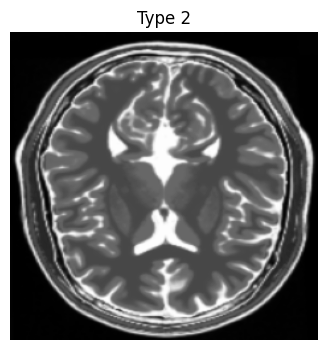

In [20]:
sample_typet2 = next(iter(typet2_data))
plt.figure(figsize=(4, 4))
plt.imshow(sample_typet2[0].numpy()[:, :, 0], cmap='gray')
plt.title('Type 2')
plt.axis('off')
plt.show()

In [21]:
plt.savefig('output_typet2.png')

<Figure size 640x480 with 0 Axes>

# Model Building

In [22]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

### Downsampling
This is done for extracting the features from images by increasing the number of channels while reducing the size of image. This is done by using Conv2D layer

In [23]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    down_layers = tf.keras.Sequential()
    #adding Conv2D layer
    down_layers.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                        kernel_initializer = initializer, use_bias = False))
    #adding normalization
    if apply_norm:
        down_layers.add(InstanceNormalization())
    #adding activation function as Leaky Relu
    down_layers.add(tf.keras.layers.LeakyReLU())
    return down_layers

### Define Resnet block
Here, the layers for residual block are defined which contains 2 Conv2d layers with 3x3 filters with ReLU as activation function and the input is concatenated to output of each block

In [24]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# first layer convolutional layer
	first = tf.keras.layers.Conv2D(n_filters, 3, padding='same', kernel_initializer=init)(input_layer)
	instancenorm1 = InstanceNormalization()(first)
	relu1 = tf.keras.layers.ReLU()(instancenorm1)
	# second convolutional layer
	second = tf.keras.layers.Conv2D(n_filters, 3, padding='same', kernel_initializer=init)(relu1)
	instancenorm2 = InstanceNormalization()(second)
	# concatenate merge channel-wise with input layer
	resnet = tf.keras.layers.Concatenate()([instancenorm2, input_layer])
	return resnet

### Upsampling
This is done the reduce the number of channels and build the image from extracted features after transformation. This reduces the number of channels but increases the size of image

In [25]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    up_layers = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    up_layers.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    up_layers.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        up_layers.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    up_layers.add(tf.keras.layers.ReLU())
    return up_layers

### Creating Unet Architecture
The  Unet architecture have following components:
- 3 Conv2d layers
- 9 Resnet blocks 
- 2 Conv2D transpose for reducing the number of channels and increasing the size of image
- 1 Conv2D layer for converting the ouput to the orginal image shape

In [26]:
def unet_generator(n_blocks = 9):
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    initializer = tf.random_normal_initializer(0., 0.02)
    g = tf.keras.layers.Conv2D(64, 7, padding = 'same', kernel_initializer = initializer)(inp)
    g = downsample(128,3) (g)
    g = downsample(256, 3) (g)

    for _ in range(n_blocks):
        g = resnet_block(256, g)
    
    g = upsample(128, 3) (g)
    g = upsample(64, 3) (g) 
    last = tf.keras.layers.Conv2D(1, 7,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    activation='tanh') (g)
    return tf.keras.Model(inputs = inp, outputs = last)

## Generator

Defining generator for MRI of T1 type to T2 type and vice versa

In [27]:
generator_g = unet_generator()
generator_f = unet_generator()

In [28]:
#checking the architecture of generator
generator_g.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      3,200 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │     73,984 │ conv2d[0][0]      │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    295,424 │ sequential[0][0]  │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ sequential_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ instance_normali… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ instance_normali… │
│ (Concatenate)       │ 512)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ instance_normali… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_6[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ instance_normali… │
│ (Concatenate)       │ 768)              │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate_1[0]

 Total params: 35,263,297 (134.52 MB)

 Trainable params: 35,263,297 (134.52 MB)

 Non-trainable params: 0 (0.00 B)

## Discriminator
Building the discriminator for the above generators

In [29]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')

    down1 = downsample(64, 4, False)(inp) #(bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) #(bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) #(bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    instancenorm = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(instancenorm)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

creating the instance of discriminator for each of the above generator 

In [30]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [31]:
#checking the architecture of discriminator
discriminator_x.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 128, 128, 64)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_46       │ (None, 31, 31, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,763,521 (10.54 MB)

 Trainable params: 2,763,521 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

Generating the image with random noise with untrained generator models

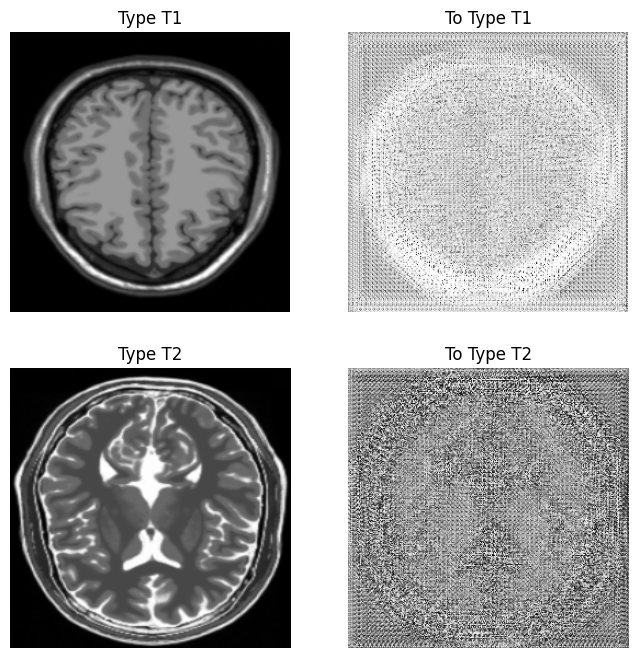

In [32]:
to_type1 = generator_g(sample_typet1)
to_type2 = generator_f(sample_typet2)
plt.figure(figsize=(8, 8))

imgs = [sample_typet1, to_type1, sample_typet2, to_type2]
title = ['Type T1', 'To Type T1', 'Type T2', 'To Type T2']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare loss as Mean Squared error loss for adversarial loss as well for discriminator loss
The least squared error loss is used for solving the problem of vanishing gradient problem which arised if binary cross entropy loss function is used, as it does not provides how much of the output is correct or nor correct, but the least squared error can provide better gradient information and give strong signal to how to update the model

In [33]:
loss_obj = tf.keras.losses.MeanSquaredError()

### Defining Discriminator loss

In [34]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [35]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, so we calculate the L1 loss between real image and cycled image

In [36]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

In [37]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

### Using linear decay learning rate scheduler 
The linear decay for learing rate is used to reduce the learning rate  which can be scheduled after a certain epoch. This is done to decrease the learning rate with each step to find the optimal minima, thus giving the better accuracy

In [38]:
class LinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: tf.cast(self._initial_learning_rate, tf.float32) * (1.0 - tf.cast(tf.math.floor(1.0 / tf.cast((self._steps - self._step_decay), tf.float32)), tf.float32)) * tf.cast((step - self._step_decay), tf.float32),

            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate


#### create the instance of learning rate scheduler for generator as well as discriminator

In [39]:
generator_lr_scheduler = LinearDecay(2e-4, EPOCHS * len_dataset, DECAY_RATE_EPOCH * len_dataset)
discriminator_lr_scheduler = LinearDecay(2e-4, EPOCHS * len_dataset, DECAY_RATE_EPOCH * len_dataset)

#### Optimizer 
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning. We have passed the scheduler as learning rate as it will handle the decay of learning rate after defined number of epochs. Here it is defined as 100

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_lr_scheduler, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=discriminator_lr_scheduler, beta_1=0.5)

#### Checkpoint Initialization
Initialize checkpoints to save models

In [41]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Function to show Images output by Generators while Training

In [42]:
def generate_images(model1, test_input1, model2, test_input2, output_dir):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(16, 8))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image T1', 'T1 to T2 Converted', 'Input Image T2', 'T2 to T1 Converted']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    plt.savefig('{}/image_at_epoch_{:03d}.png'.format(output_dir, epoch))
    plt.show()

#### Training FLow
Below Function performs one Flow of Batch Training <p>
Notice that Identity Loss and Cycle Loss are only used in training Generator and not Discriminator

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss: Generator Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [43]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        total_gen_loss = total_gen_g_loss + total_gen_f_loss
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        total_disc_loss = disc_x_loss + disc_y_loss
        
    # Calculate the gradients for generator and discriminator
    generator_gradients = tape.gradient(total_gen_loss, generator_g.trainable_variables + generator_f.trainable_variables)
    discriminator_gradients = tape.gradient(total_disc_loss, discriminator_x.trainable_variables + discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(generator_gradients, generator_g.trainable_variables + generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_x.trainable_variables + discriminator_y.trainable_variables))

#### Train the CycleGAN Model for the 200 Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

In [1]:
"""for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((typet1_data, typet2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_typet1, generator_f, sample_typet2, 'OutputImages')
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)"""

"for epoch in range(1, EPOCHS+1):\n    for image_x, image_y in tf.data.Dataset.zip((typet1_data, typet2_data)):\n        train_step(image_x, image_y)\n    generate_images(generator_g, sample_typet1, generator_f, sample_typet2, 'OutputImages')\n    ckpt_save_path = ckpt_manager.save()\n    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)"

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [ ]:
As you can see from the above training in the final epochs, the CycleGAN is successfully able to convert MRI from T1 type to T2 type 